### Contexte du projet et données

L’objectif de ce projet est de localiser et classifier l’espèce d’une plante dans une image. Une fois la classification faite, il faut retourner à l’utilisateur une description de celle-ci et identifier les possibles maladies. L’application sera donc capable à partir d’une image prise par l'appareil photo de donner une succession d’informations à l’utilisateur.

Pour ce faire, nous disposons de 4 datasets :
- Pour identifier l'espèce de la plante :
    - [V2 Plant Seedlings Dataset ](https://www.kaggle.com/datasets/vbookshelf/v2-plant-seedlings-dataset)
- Pour identifier la maladie de la plante :
    - [New Plant Diseases Dataset](https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset)
    - [Plant Disease](https://www.kaggle.com/datasets/saroz014/plant-disease)
    - [PlantVillage Dataset](https://www.kaggle.com/datasets/abdallahalidev/plantvillage-dataset)

In [1]:
import numpy as np
import pandas as pd
import cv2
from matplotlib import pyplot as plt
import os
import shutil
import seaborn as sns
from tqdm import tqdm
from collections import Counter
import random
from functools import reduce
import albumentations as A

import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

In [4]:
color_path = './data/plant_village/color/'
directories = sorted(os.listdir(color_path))
proportion_of_colored_pxl_per_class = []

for directory in directories:
    
    proportion_of_colored_pxl_per_image = []
    print(directory)
    class_path = os.path.join(color_path, directory)
    print(class_path)
    for image in tqdm(os.scandir(class_path)):     
        image = image.path  
        image = cv2.imread(image, 0)
        image = cv2.resize(image, (256, 256)) 
        
        proportion_of_colored_pxl_per_image.append(np.count_nonzero(image) / (65536))
        
    proportion_of_colored_pxl_per_class.append(proportion_of_colored_pxl_per_image)

Apple___Apple_scab
./data/plant_village/color/Apple___Apple_scab


483it [00:00, 1785.19it/s]


error: OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/imgproc/src/resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'resize'


L’objectif de ce projet est de localiser et classifier l’espèce d’une plante dans une image. Une fois la classification faite, il faut retourner à l’utilisateur une description de celle-ci et identifier les possibles maladies. L’application sera donc capable à partir d’une image prise par l'appareil photo de donner une succession d’informations à l’utilisateur.

Pour ce faire, nous disposons de 4 datasets :
- Pour identifier l'espèce de la plante :
    - [V2 Plant Seedlings Dataset ](https://www.kaggle.com/datasets/vbookshelf/v2-plant-seedlings-dataset)
- Pour identifier la maladie de la plante :
    - [New Plant Diseases Dataset](https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset)
    - [Plant Disease](https://www.kaggle.com/datasets/saroz014/plant-disease)
    - [PlantVillage Dataset](https://www.kaggle.com/datasets/abdallahalidev/plantvillage-dataset)

Le premier jeu de donnée permettant d'identifier la plante est composé de 12 classes correspondants à 12 especes de plantes différentes.
Une première observation de quelques images, nous permet d'identifier un background de gravier derrière les plantes et parfois une regle de mesure sur les bordures. Nous sommes sur un dataset de plantes en croissances (seedlings). Les plantes, notre information utile ici, sont parfois très petites par rapport au background. Les images ne sont pas toutes cadrés de la même facon et nous avons differentes dimensions possibles.


On commence par importer les bibliotheques utiles.
Pour la lecture des images j'importe OpenCV (cv2)

In [422]:
import os
import cv2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statistics import mode

Les images sont répartis dans des sous-dossiers, triées par classes. Il fuat parcourir chaque sous dossiers pour recupere les informations de toutes les images et les enregistrer dans un dataframe.

In [459]:
# Chemin vers le dossier principal contenant les sous-dossiers par classe
dataset_path = './data/v2_plant_seedlings'

# Liste pour stocker les chemins des images, les noms des classes
chemins_images = []
noms_classes = []

# Parcourir tous les sous-dossiers
for classe in os.listdir(dataset_path):
    classe_path = os.path.join(dataset_path, classe)
    
    # Se placer dans un sous-dossier
    if os.path.isdir(classe_path):
        # Parcourir tous les fichiers dans le sous-dossier
        for fichier in os.listdir(classe_path):
            # Ne recuperer que les images
            if fichier.endswith((".png",".jpeg")):
                image_path = os.path.join(classe_path, fichier)
                
                # Lire l'image avec OpenCV en mode RGB
                image = cv2.imread(image_path, cv2.IMREAD_COLOR)
                image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

                # Ajouter les informations au DataFrame
                chemins_images.append(image_path)
                noms_classes.append(classe)

# Création du DataFrame
df = pd.DataFrame({
    'Chemin_Image': chemins_images,
    'Classe': noms_classes})
df.head()

Chemin_Image    Classe
0  ./data/v2_plant_seedlings/Cleavers/348.png  Cleavers
1  ./data/v2_plant_seedlings/Cleavers/176.png  Cleavers
2   ./data/v2_plant_seedlings/Cleavers/88.png  Cleavers
3  ./data/v2_plant_seedlings/Cleavers/162.png  Cleavers
4  ./data/v2_plant_seedlings/Cleavers/189.png  Cleavers

In [424]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5539 entries, 0 to 5538
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Chemin_Image  5539 non-null   object
 1   Classe        5539 non-null   object
dtypes: object(2)
memory usage: 86.7+ KB


Avec les informations presentes dans le dataframe nous pouvons afficher une distribution des classes.

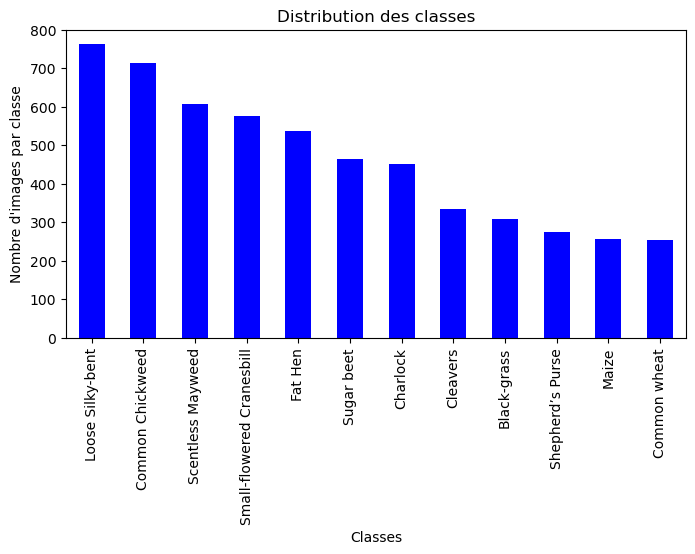

In [427]:
# Exploration de la distribution des classes
distribution_classes = df['Classe'].value_counts()

# Affichage de la distribution des classes
plt.figure(figsize=(8, 4))
distribution_classes.plot(kind='bar', color='b')
plt.title('Distribution des classes')
plt.xlabel('Classes')
plt.ylabel('Nombre d\'images par classe')
plt.show()

In [461]:
resolutions = []
aspect_ratios = []
modes_couleur = []
largeurs =[]
hauteurs =[]

for classe in os.listdir(dataset_path):
    classe_path = os.path.join(dataset_path, classe)
    
    # Assurez-vous que l'élément est un sous-dossier
    if os.path.isdir(classe_path):
        # Parcours de tous les fichiers dans le sous-dossier
        for fichier in os.listdir(classe_path):
            if fichier.endswith(".png"):
                image_path = os.path.join(classe_path, fichier)
                
                # Lire l'image avec OpenCV en mode RGB
                image = cv2.imread(image_path, cv2.IMREAD_COLOR)
                image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

                # Obtenez les détails sur l'image
                hauteur, largeur, canaux = image.shape

                # Calculer la résolution
                ratio_image = largeur / hauteur

                # Déterminer le mode de couleur
                mode_couleur = "RGB" if canaux == 3 else "Autre"
                
                # Ajouter des informations au DataFrame
                resolutions.append(f"{largeur}x{hauteur}")
                largeurs.append(largeur)
                hauteurs.append(hauteur)
                aspect_ratios.append(ratio_image)
                modes_couleur.append(mode_couleur) 
                
df['Resolution'] = resolutions
df['Largeur'] = largeurs
df['Hauteur'] = hauteurs
df['Aspect_Ratio'] = aspect_ratios
df['Mode_Couleur'] =  modes_couleur

df.head()

Chemin_Image    Classe Resolution  Largeur  \
0  ./data/v2_plant_seedlings/Cleavers/348.png  Cleavers    450x450      450   
1  ./data/v2_plant_seedlings/Cleavers/176.png  Cleavers    295x295      295   
2   ./data/v2_plant_seedlings/Cleavers/88.png  Cleavers    299x299      299   
3  ./data/v2_plant_seedlings/Cleavers/162.png  Cleavers    194x194      194   
4  ./data/v2_plant_seedlings/Cleavers/189.png  Cleavers    438x438      438   

   Hauteur  Aspect_Ratio Mode_Couleur  
0      450           1.0          RGB  
1      295           1.0          RGB  
2      299           1.0          RGB  
3      194           1.0          RGB  
4      438           1.0          RGB

In [429]:
df = df.set_index('Chemin_Image')
df.head()

Classe Resolution  Largeur  \
Chemin_Image                                                               
./data/v2_plant_seedlings/Cleavers/348.png  Cleavers    450x450      450   
./data/v2_plant_seedlings/Cleavers/176.png  Cleavers    295x295      295   
./data/v2_plant_seedlings/Cleavers/88.png   Cleavers    299x299      299   
./data/v2_plant_seedlings/Cleavers/162.png  Cleavers    194x194      194   
./data/v2_plant_seedlings/Cleavers/189.png  Cleavers    438x438      438   

                                            Hauteur Encodage  Aspect_Ratio  \
Chemin_Image                                                                 
./data/v2_plant_seedlings/Cleavers/348.png      450    uint8           1.0   
./data/v2_plant_seedlings/Cleavers/176.png      295    uint8           1.0   
./data/v2_plant_seedlings/Cleavers/88.png       299    uint8           1.0   
./data/v2_plant_seedlings/Cleavers/162.png      194    uint8           1.0   
./data/v2_plant_seedlings/Cleavers/189.png      438    uint8           1.0   

                                           Mode_Couleur  
Chemin_Image                                             
./data/v2_plant_seedlings/Cleavers/348.png          RGB  
./data/v2_plant_seedlings/Cleavers/176.png          RGB  
./data/v2_plant_seedlings/Cleavers/88.png           RGB  
./data/v2_plant_seedlings/Cleavers/162.png          RGB  
./data/v2_plant_seedlings/Cleavers/189.png          RGB

In [431]:
df.Mode_Couleur.value_counts()

Mode_Couleur
RGB    5539
Name: count, dtype: int64

In [432]:
df.Aspect_Ratio.value_counts()

Aspect_Ratio
1.000000    5471
0.943368      13
1.000515       3
1.095368       3
1.047423       3
1.111111       2
1.062261       2
0.952703       2
1.000995       2
1.000527       1
1.000758       1
1.000672       1
1.332083       1
1.030303       1
1.001629       1
1.000870       1
1.000703       1
1.013575       1
1.000398       1
1.134459       1
1.000930       1
1.053857       1
1.000658       1
1.000479       1
1.000441       1
1.000574       1
1.000880       1
1.034398       1
0.956522       1
1.093333       1
1.000708       1
1.115843       1
1.056370       1
1.066169       1
1.041322       1
1.056407       1
1.007273       1
1.011407       1
1.001271       1
1.048780       1
0.987179       1
1.058442       1
1.027418       1
1.065472       1
1.011873       1
1.118182       1
1.000826       1
Name: count, dtype: int64

La majoritée des aspect ratio sont de 1.0 mais certaines images sont légerements inferieures ou superieurs, ce qui peut entrainer une légère déformation de l'image lors de l'etape de standardisation.

In [433]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5539 entries, ./data/v2_plant_seedlings/Cleavers/348.png to ./data/v2_plant_seedlings/Maize/153.png
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Classe        5539 non-null   object 
 1   Resolution    5539 non-null   object 
 2   Largeur       5539 non-null   int64  
 3   Hauteur       5539 non-null   int64  
 4   Encodage      5539 non-null   object 
 5   Aspect_Ratio  5539 non-null   float64
 6   Mode_Couleur  5539 non-null   object 
dtypes: float64(1), int64(2), object(4)
memory usage: 346.2+ KB


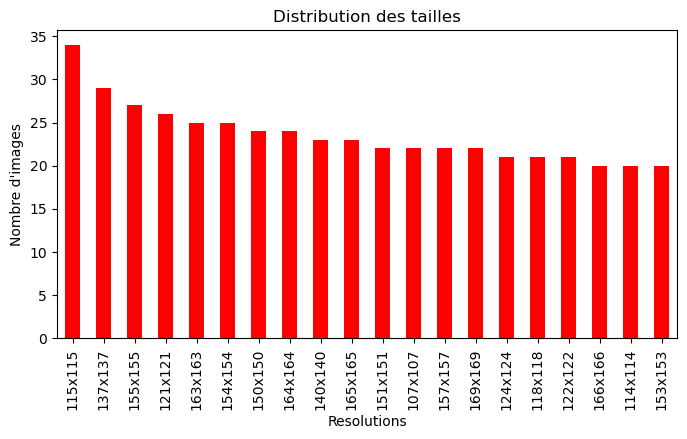

In [434]:
# Exploration de la distribution des classes
distribution_dimensions = df['Resolution'].value_counts().head(20)

# Affichage de la distribution des classes
plt.figure(figsize=(8, 4))
distribution_dimensions.plot(kind='bar', color='r')
plt.title('Distribution des tailles')
plt.xlabel('Resolutions')
plt.ylabel('Nombre d\'images')
plt.show()

In [435]:
print(df.Largeur.mean())
print(df.Hauteur.mean())

355.2020220256364
354.7835349341036


Du au nombre de Resolutions trop nombreuses, un boxplot nous permettra de voir la distribution en fonction des quartiles et nous apportera une visibilité des valeurs aberrantes si elles existent.

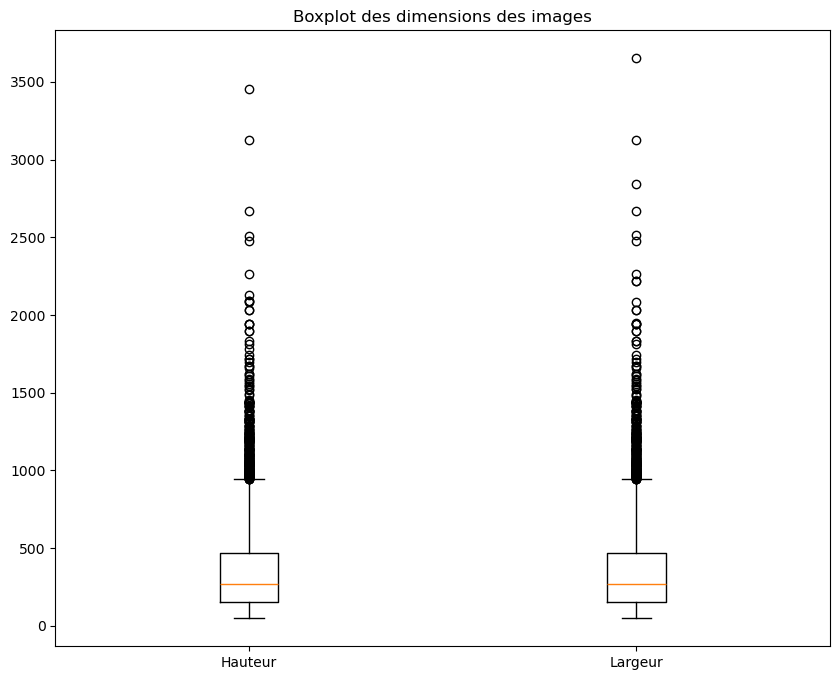

In [436]:
plt.figure(figsize=(10, 8))
plt.boxplot([df['Hauteur'], df['Largeur']], labels=['Hauteur', 'Largeur'])
plt.title('Boxplot des dimensions des images')
plt.show()

In [454]:
print('Hauteur max : ',df.Hauteur.max())
print('Hauteur min : ',df.Hauteur.min())
print('Largeur max : ',df.Largeur.max())
print('Largeur min : ',df.Largeur.min())

Hauteur max :  3457
Hauteur min :  49
Largeur max :  3652
Largeur min :  49


In [457]:
print(df.Hauteur.std())
print(df.Largeur.std())

292.70046127775674
295.10859994199467


Dû au nombre important de valeur aberrantes, la moyenne calculée precedemment n'est plus representative du dataset, la mediane sera plus adaptée. Nous constatons egalement qu'une normalisation des données de dimensions dera necessaire.

In [438]:
print(df.Largeur.median())
print(df.Hauteur.median())

267.0
267.0


Nous nous interessons maintenant aux intensitées des canaux de couleur

In [439]:
intensitees_rouge = []
intensitees_vert = []
intensitees_bleu = []

# Parcours de tous les sous-dossiers
for classe in os.listdir(dataset_path):
    classe_path = os.path.join(dataset_path, classe)
    
    # Assurez-vous que l'élément est un sous-dossier
    if os.path.isdir(classe_path):
        # Parcours de tous les fichiers dans le sous-dossier
        for fichier in os.listdir(classe_path):
            if fichier.endswith(".png"):
                image_path = os.path.join(classe_path, fichier)
                
                # Lire l'image avec OpenCV en mode RGB
                image = cv2.imread(image_path, cv2.IMREAD_COLOR)
                image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
                
                # Calculer les histogrammes d'intensité pour chaque canal
                histogramme_rouge = cv2.calcHist([image], [0], None, [256], [0, 256])
                histogramme_vert = cv2.calcHist([image], [1], None, [256], [0, 256])
                histogramme_bleu = cv2.calcHist([image], [2], None, [256], [0, 256])
                
                # Ajouter des informations au DataFrame
                intensitees_rouge.append(histogramme_rouge)
                intensitees_vert.append(histogramme_vert)
                intensitees_bleu.append(histogramme_bleu)
                
df['Intensitee_Rouge'] = intensitees_rouge
df['Intensitee_Vert'] = intensitees_vert
df['Intensitee_Bleu'] = intensitees_bleu

df.head()

Classe Resolution  Largeur  \
Chemin_Image                                                               
./data/v2_plant_seedlings/Cleavers/348.png  Cleavers    450x450      450   
./data/v2_plant_seedlings/Cleavers/176.png  Cleavers    295x295      295   
./data/v2_plant_seedlings/Cleavers/88.png   Cleavers    299x299      299   
./data/v2_plant_seedlings/Cleavers/162.png  Cleavers    194x194      194   
./data/v2_plant_seedlings/Cleavers/189.png  Cleavers    438x438      438   

                                            Hauteur Encodage  Aspect_Ratio  \
Chemin_Image                                                                 
./data/v2_plant_seedlings/Cleavers/348.png      450    uint8           1.0   
./data/v2_plant_seedlings/Cleavers/176.png      295    uint8           1.0   
./data/v2_plant_seedlings/Cleavers/88.png       299    uint8           1.0   
./data/v2_plant_seedlings/Cleavers/162.png      194    uint8           1.0   
./data/v2_plant_seedlings/Cleavers/189.png      438    uint8           1.0   

                                           Mode_Couleur  \
Chemin_Image                                              
./data/v2_plant_seedlings/Cleavers/348.png          RGB   
./data/v2_plant_seedlings/Cleavers/176.png          RGB   
./data/v2_plant_seedlings/Cleavers/88.png           RGB   
./data/v2_plant_seedlings/Cleavers/162.png          RGB   
./data/v2_plant_seedlings/Cleavers/189.png          RGB   

                                                                             Intensitee_Rouge  \
Chemin_Image                                                                                    
./data/v2_plant_seedlings/Cleavers/348.png  [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....   
./data/v2_plant_seedlings/Cleavers/176.png  [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....   
./data/v2_plant_seedlings/Cleavers/88.png   [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....   
./data/v2_plant_seedlings/Cleavers/162.png  [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....   
./data/v2_plant_seedlings/Cleavers/189.png  [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....   

                                                                              Intensitee_Vert  \
Chemin_Image                                                                                    
./data/v2_plant_seedlings/Cleavers/348.png  [[5.0], [4.0], [5.0], [8.0], [11.0], [17.0], [...   
./data/v2_plant_seedlings/Cleavers/176.png  [[0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0....   
./data/v2_plant_seedlings/Cleavers/88.png   [[2.0], [1.0], [0.0], [2.0], [1.0], [1.0], [3....   
./data/v2_plant_seedlings/Cleavers/162.png  [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....   
./data/v2_plant_seedlings/Cleavers/189.png  [[0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1....   

                                                                              Intensitee_Bleu  
Chemin_Image                                                                                   
./data/v2_plant_seedlings/Cleavers/348.png  [[49.0], [15.0], [29.0], [42.0], [41.0], [33.0...  
./data/v2_plant_seedlings/Cleavers/176.png  [[15.0], [1.0], [6.0], [7.0], [8.0], [10.0], [...  
./data/v2_plant_seedlings/Cleavers/88.png   [[77.0], [14.0], [17.0], [21.0], [24.0], [25.0...  
./data/v2_plant_seedlings/Cleavers/162.png  [[18.0], [5.0], [12.0], [12.0], [25.0], [13.0]...  
./data/v2_plant_seedlings/Cleavers/189.png  [[32.0], [8.0], [10.0], [12.0], [21.0], [12.0]...

In [440]:
moyennes_classe = df.groupby('Classe').agg({
    'Intensitee_Rouge': 'mean',
    'Intensitee_Vert': 'mean',
    'Intensitee_Bleu': 'mean'
})
moyennes_classe

Intensitee_Rouge  \
Classe                                                                         
Black-grass                [[0.6440129], [0.41747573], [0.53721684], [0.9...   
Charlock                   [[0.1039823], [0.097345136], [0.13716814], [0....   
Cleavers                   [[0.017910447], [0.047761194], [0.08955224], [...   
Common Chickweed           [[0.026647966], [0.019635344], [0.039270688], ...   
Common wheat               [[0.07114624], [0.13043478], [0.25296444], [0....   
Fat Hen                    [[0.16914499], [0.12639405], [0.15055762], [0....   
Loose Silky-bent           [[0.1167979], [0.10761155], [0.12992126], [0.1...   
Maize                      [[0.050583657], [0.027237354], [0.038910504], ...   
Scentless Mayweed          [[0.039538715], [0.034596376], [0.06919275], [...   
Shepherd’s Purse           [[0.310219], [0.12773722], [0.18613139], [0.28...   
Small-flowered Cranesbill  [[0.18055555], [0.1423611], [0.2361111], [0.37...   
Sugar beet                 [[0.034557234], [0.056155507], [0.082073435], ...   

                                                             Intensitee_Vert  \
Classe                                                                         
Black-grass                [[18.666666], [8.893204], [11.530745], [14.977...   
Charlock                   [[6.64823], [2.738938], [3.6460178], [4.962389...   
Cleavers                   [[5.435821], [2.402985], [3.3313432], [4.08059...   
Common Chickweed           [[2.6591866], [1.2945302], [1.5469846], [1.915...   
Common wheat               [[18.177866], [7.624506], [9.814229], [11.9960...   
Fat Hen                    [[5.875465], [2.7044609], [3.3048327], [4.1951...   
Loose Silky-bent           [[6.7637796], [3.288714], [4.2795277], [5.6469...   
Maize                      [[3.4163425], [1.9805448], [2.7315176], [3.190...   
Scentless Mayweed          [[2.9143329], [1.3855025], [1.7265239], [2.457...   
Shepherd’s Purse           [[4.1569343], [1.7700729], [2.2992702], [3.091...   
Small-flowered Cranesbill  [[12.53993], [5.5815973], [7.5416665], [9.8732...   
Sugar beet                 [[8.444924], [3.5313175], [4.7192225], [6.3930...   

                                                             Intensitee_Bleu  
Classe                                                                        
Black-grass                [[474.15533], [93.048546], [109.15534], [125.4...  
Charlock                   [[797.26324], [111.701324], [128.93805], [146....  
Cleavers                   [[69.71343], [14.895522], [18.59403], [21.6865...  
Common Chickweed           [[594.3057], [129.5512], [151.45862], [174.517...  
Common wheat               [[166.94467], [34.359684], [38.612648], [46.05...  
Fat Hen                    [[124.09108], [27.98327], [33.45539], [40.6431...  
Loose Silky-bent           [[287.51706], [52.812336], [60.92651], [71.291...  
Maize                      [[1816.4863], [247.07393], [272.4358], [298.13...  
Scentless Mayweed          [[284.10873], [47.01153], [53.514004], [60.014...  
Shepherd’s Purse           [[1650.1752], [300.56934], [335.90146], [371.9...  
Small-flowered Cranesbill  [[320.62674], [83.82465], [102.25347], [123.75...  
Sugar beet                 [[2613.704], [338.473], [363.31534], [393.2073...

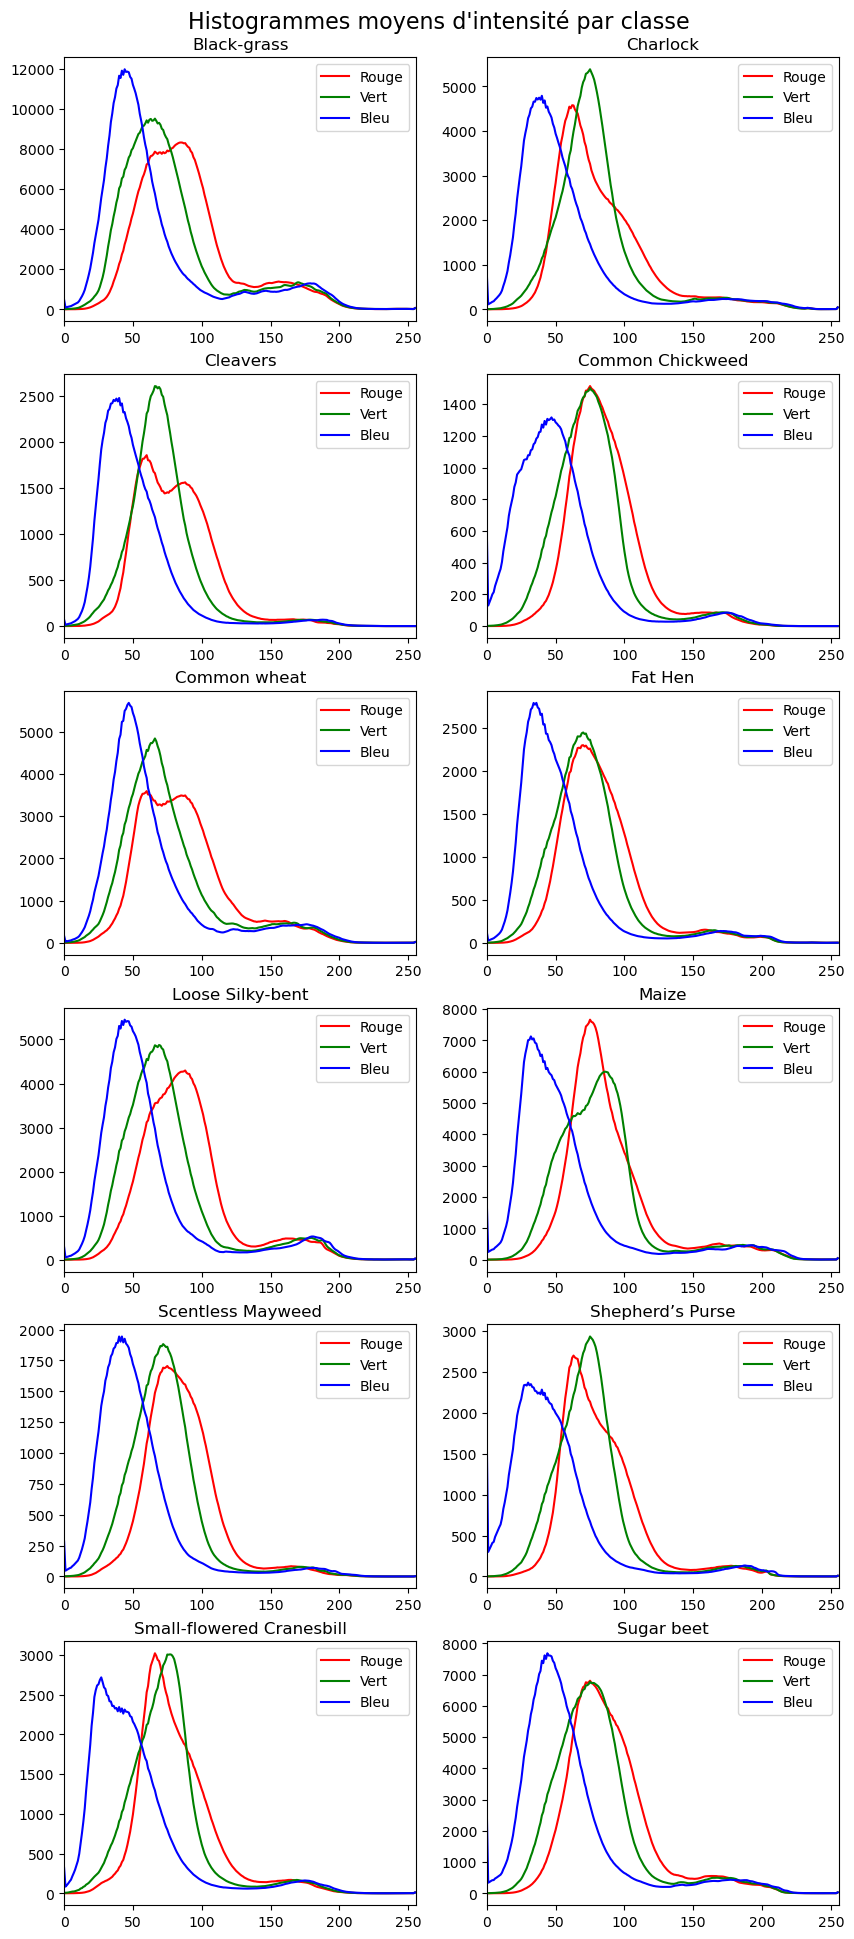

In [444]:
# Initialiser un subplot avec 2 colonnes et 3 lignes
num_rows = len(moyennes_classe)//2
fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(10, 4*num_rows))

# Parcourir les classes et les axes
for i, (classe, moyennes) in enumerate(moyennes_classe.iterrows()):
    row = i // 2
    col = i % 2
    # Tracer les courbes pour chaque intensité
    axes[row, col].plot(moyennes['Intensitee_Rouge'], label='Rouge', color='red')
    axes[row, col].plot(moyennes['Intensitee_Vert'], label='Vert', color='green')
    axes[row, col].plot(moyennes['Intensitee_Bleu'], label='Bleu', color='blue')

    axes[row, col].set_title(classe)
    axes[row, col].legend()
    axes[row, col].set_xlim([0, 256])

# Ajuster le style du subplot
plt.suptitle('Histogrammes moyens d\'intensité par classe', fontsize=16, y = 0.9)
plt.show()

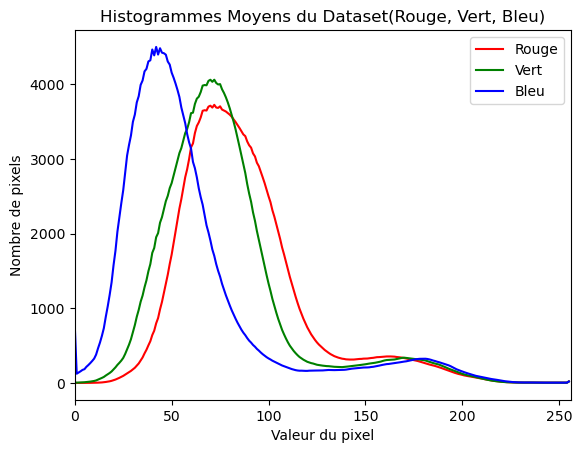

In [445]:
# Afficher les histogrammes moyens superposés
plt.plot(moyennes_classe['Intensitee_Rouge'].mean(), color='red', label='Rouge')
plt.plot(moyennes_classe['Intensitee_Vert'].mean(), color='green', label='Vert')
plt.plot(moyennes_classe['Intensitee_Bleu'].mean(), color='blue', label='Bleu')

plt.title('Histogrammes Moyens du Dataset(Rouge, Vert, Bleu)')
plt.xlabel('Valeur du pixel')
plt.ylabel('Nombre de pixels')
plt.xlim([0,256])
plt.legend()
plt.show()

In [410]:
# Duplicate
df.duplicated(subset=['Intensitee_Rouge']).any()

False

In [411]:
# Duplicate
df.duplicated(subset=['Intensitee_Vert']).any()

False

In [412]:
# Duplicate
df.duplicated(subset=['Intensitee_Bleu']).any()

False

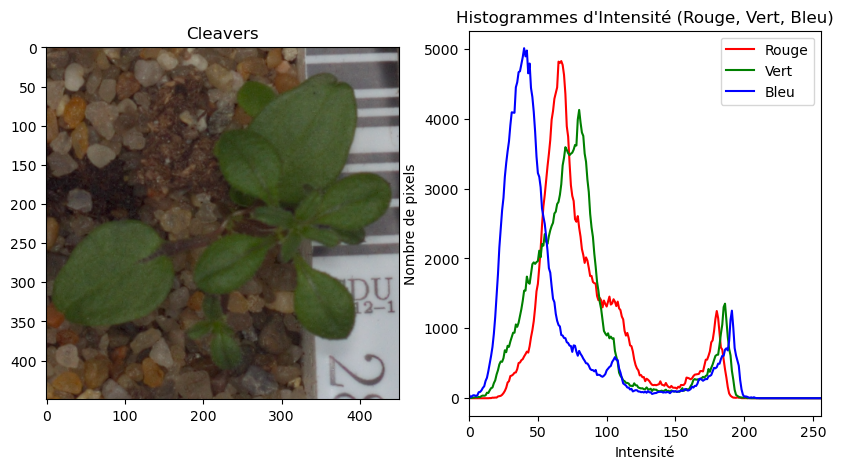

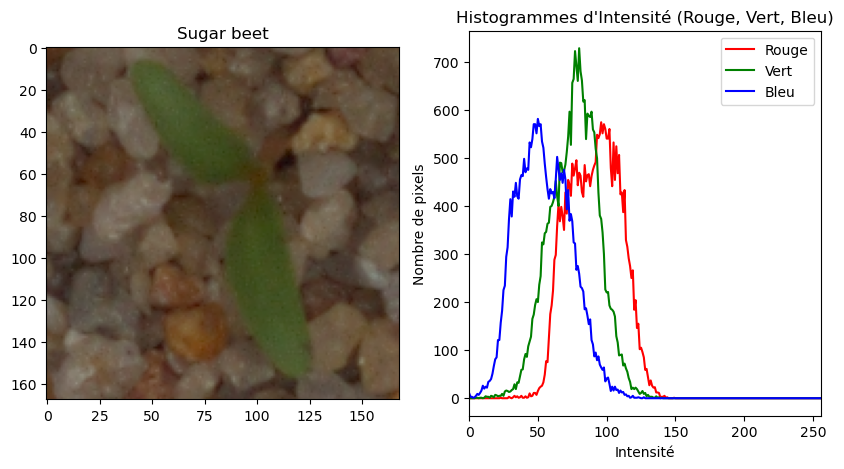

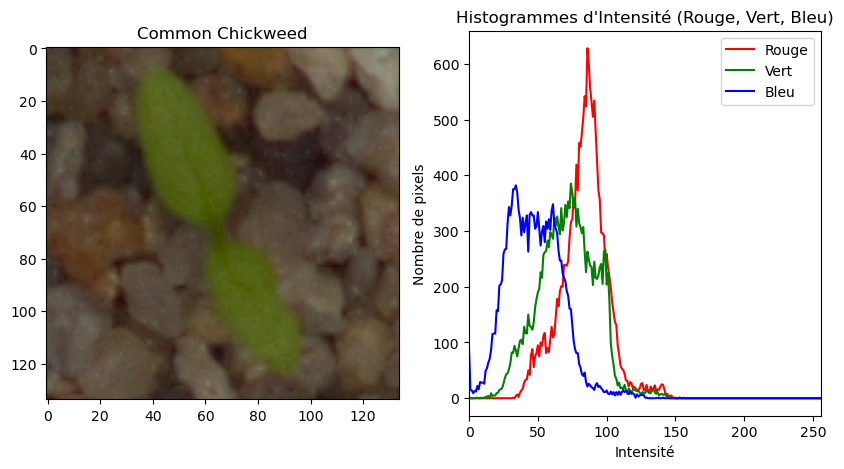

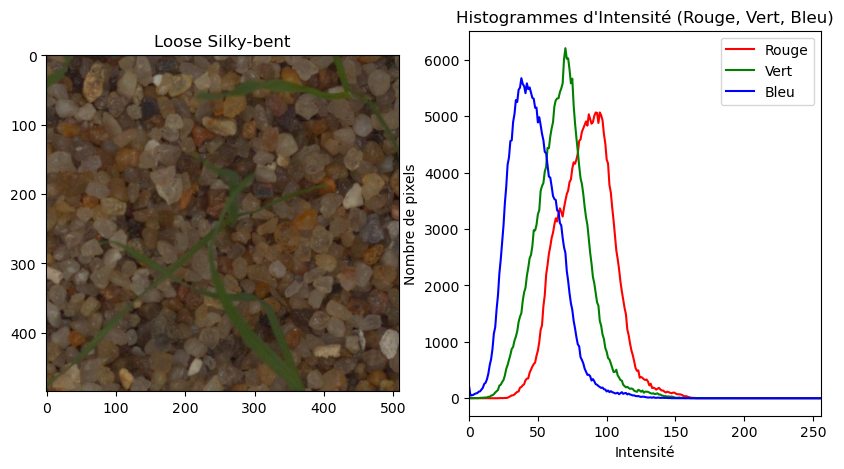

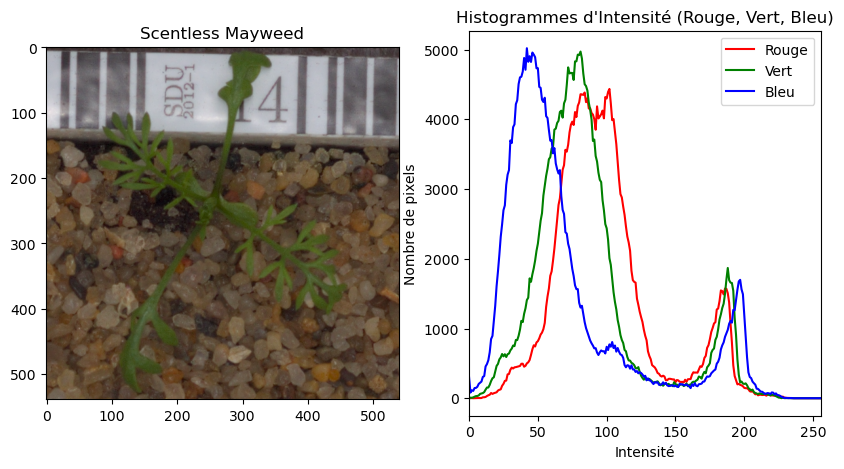

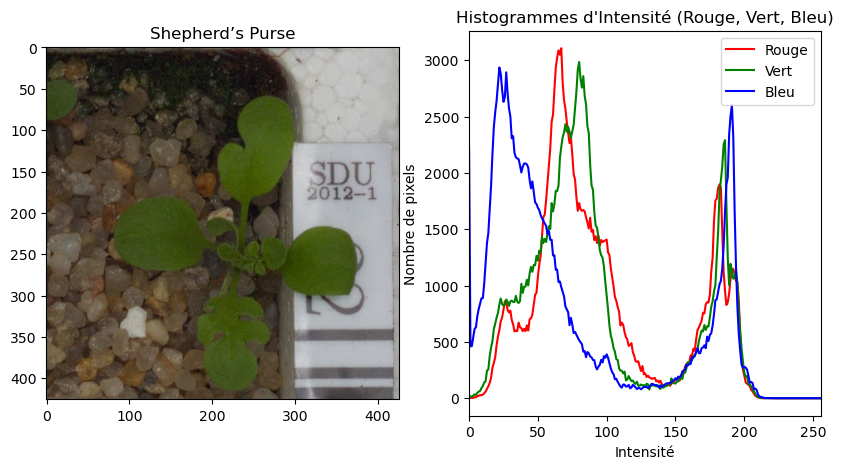

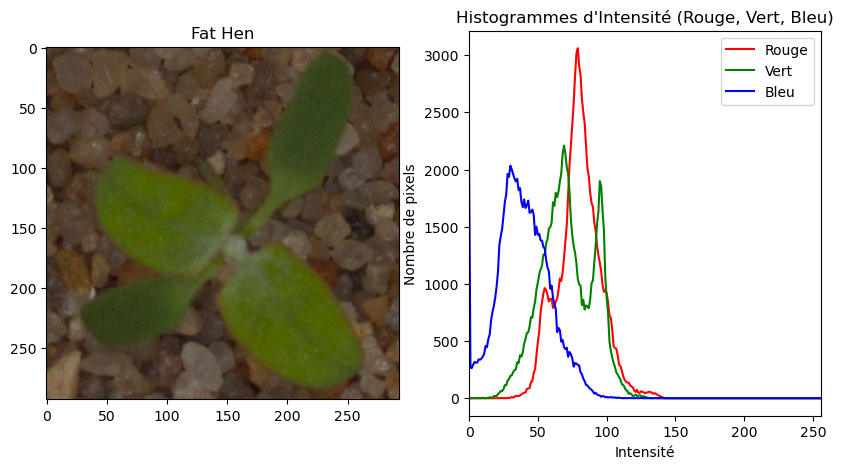

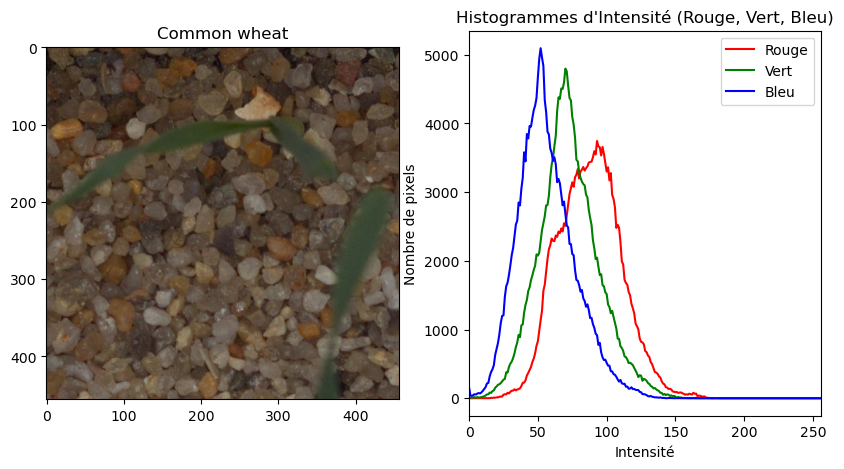

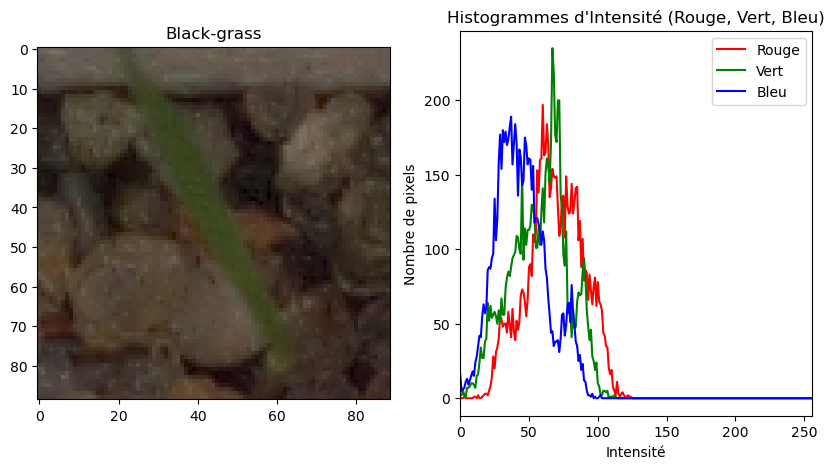

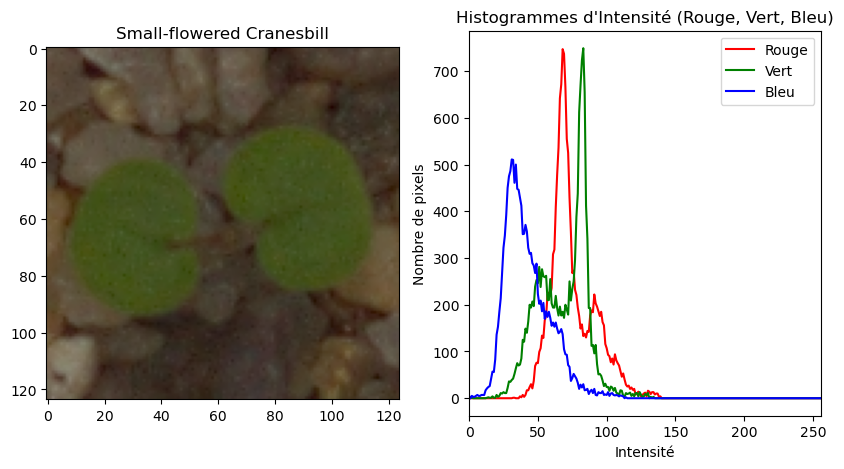

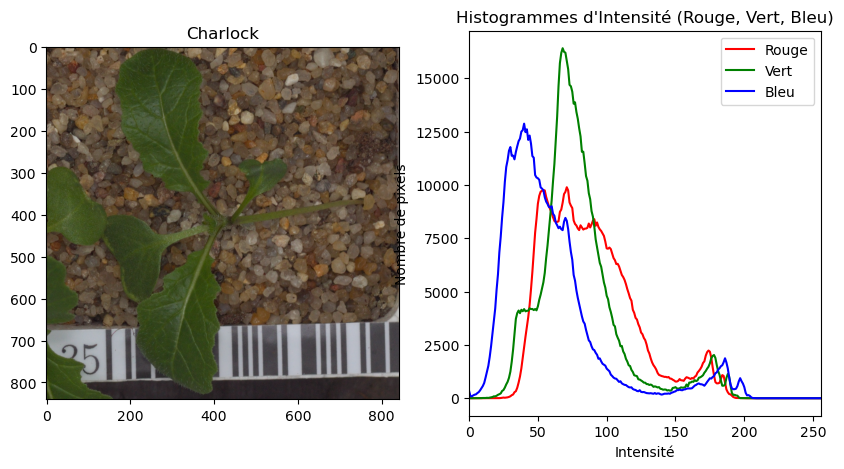

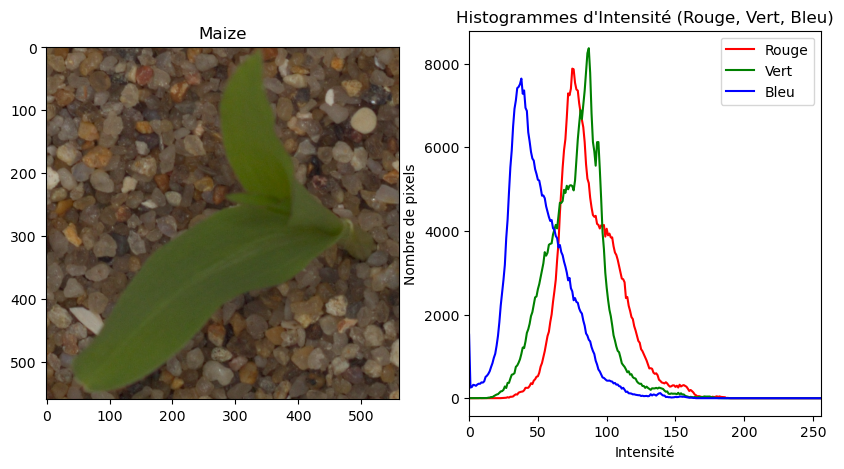

In [451]:
# Parcours de tous les sous-dossiers
for classe in os.listdir(dataset_path):
    classe_path = os.path.join(dataset_path, classe)

    # Assurez-vous que l'élément est un sous-dossier
    if os.path.isdir(classe_path):
        # Parcours de tous les fichiers dans le sous-dossier
        for fichier in os.listdir(classe_path):
            if fichier.endswith(".png"):
                image_path = os.path.join(classe_path, fichier)

                # Lire l'image avec OpenCV en mode RGB
                image = cv2.imread(image_path, cv2.IMREAD_COLOR)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                # Calculer les histogrammes d'intensité pour chaque canal
                histogramme_rouge = cv2.calcHist([image], [0], None, [256], [0, 256])
                histogramme_vert = cv2.calcHist([image], [1], None, [256], [0, 256])
                histogramme_bleu = cv2.calcHist([image], [2], None, [256], [0, 256])

                # Afficher l'image et l'histogramme côte à côte
                fig, axes = plt.subplots(1, 2, figsize=(10, 5))

                # Afficher l'image
                axes[0].imshow(image)
                axes[0].set_title(classe)

                # Afficher les histogrammes
                axes[1].plot(histogramme_rouge, color='red', label='Rouge')
                axes[1].plot(histogramme_vert, color='green', label='Vert')
                axes[1].plot(histogramme_bleu, color='blue', label='Bleu')
                axes[1].set_title('Histogrammes d\'Intensité (Rouge, Vert, Bleu)')
                axes[1].set_xlabel('Intensité')
                axes[1].set_ylabel('Nombre de pixels')
                axes[1].set_xlim([0, 256])
                axes[1].legend()

                # Afficher le plot
                plt.show()

                # Afficher uniquement la première image de chaque classe
                break

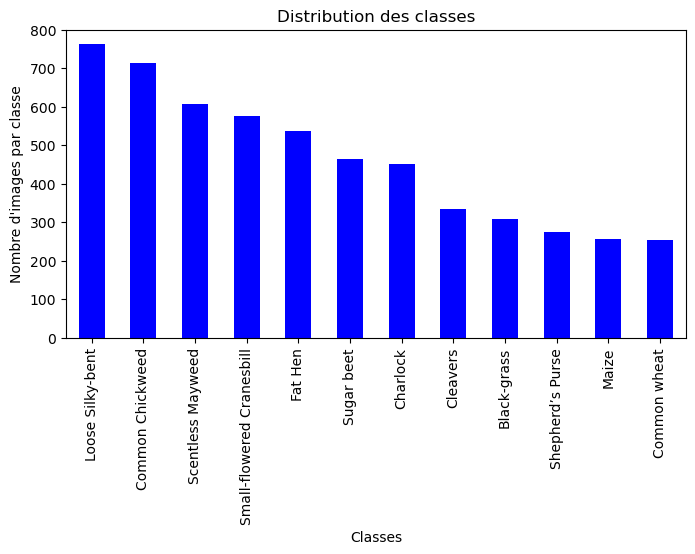

In [420]:
# Exploration de la distribution des classes
distribution_classes2 = df2['Classe'].value_counts()

# Affichage de la distribution des classes
plt.figure(figsize=(8, 4))
distribution_classes.plot(kind='bar', color='b')
plt.title('Distribution des classes')
plt.xlabel('Classes')
plt.ylabel('Nombre d\'images par classe')
plt.show()

In [421]:
resolutions2 = []
encodages2 = []
aspect_ratios2 = []
modes_couleur2 = []
largeurs2 =[]
hauteurs2 =[]

for classe in os.listdir(dataset2_path):
    classe_path = os.path.join(dataset2_path, classe)
    
    # Assurez-vous que l'élément est un sous-dossier
    if os.path.isdir(classe_path):
        # Parcours de tous les fichiers dans le sous-dossier
        for fichier in os.listdir(classe_path):
            if fichier.endswith(".png"):
                image_path = os.path.join(classe_path, fichier)
                
                # Lire l'image avec OpenCV en mode RGB
                image = cv2.imread(image_path, cv2.IMREAD_COLOR)
                image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

                # Obtenez les détails sur l'encodage
                hauteur, largeur, canaux = image.shape
                encodage = image.dtype

                # Calculer la résolution
                ratio_image = largeur / hauteur

                # Déterminer le mode de couleur
                mode_couleur = "RGB" if canaux == 3 else "Autre"
                
                # Ajouter des informations au DataFrame
                resolutions2.append(f"{largeur}x{hauteur}")
                largeurs2.append(largeur)
                hauteurs2.append(hauteur)
                encodages2.append(encodage)
                aspect_ratios2.append(ratio_image)
                modes_couleur2.append(mode_couleur) 
                
df2['Resolution'] = resolutions2
df2['Largeur'] = largeurs2
df2['Hauteur'] = hauteurs2
df2['Encodage'] = encodages2
df2['Aspect_Ratio'] = aspect_ratios2
df2['Mode_Couleur'] =  modes_couleur2

df2.head()

Chemin_Image    Classe Resolution  \
0  ./data/v2_plant_seedlings/nonsegmentedv2/Cleav...  Cleavers    450x450   
1  ./data/v2_plant_seedlings/nonsegmentedv2/Cleav...  Cleavers    295x295   
2  ./data/v2_plant_seedlings/nonsegmentedv2/Cleav...  Cleavers    299x299   
3  ./data/v2_plant_seedlings/nonsegmentedv2/Cleav...  Cleavers    194x194   
4  ./data/v2_plant_seedlings/nonsegmentedv2/Cleav...  Cleavers    438x438   

   Largeur  Hauteur Encodage  Aspect_Ratio Mode_Couleur  
0      450      450    uint8           1.0          RGB  
1      295      295    uint8           1.0          RGB  
2      299      299    uint8           1.0          RGB  
3      194      194    uint8           1.0          RGB  
4      438      438    uint8           1.0          RGB